# tf.data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
assert sys.version_info >= (3, 5)

from pathlib import Path
from pprint import pprint
import glob
import shutil
import json
import csv
import itertools
import pandas as pd
import numpy as np
from functools import partial
from time import time
from typing import List, Optional, Union

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

fdir = Path.cwd()
print(fdir)
# sys.path.append(str(fdir/'../src'))
sys.path.append(str(fdir/'..'))
import src
# from config import cfg
from src.config import cfg
from src.ml.scale import get_scaler
from src.utils.utils import Params, dump_dict, read_lines, cast_list, Timer
from src.datasets.tidy import split_data_and_extract_fea, extract_fea

from src.tf_utils import (calc_records_in_tfr_folder, calc_examples_in_tfrecord, get_tfr_files,
                          _float_feature, _bytes_feature, _int64_feature)
from src.sf_utils import read_annotations, green, parse_tfrec_fn_rsp, create_tf_data
from src.tfrecords import FEA_SPEC_RNA, FEA_SPEC_RSP_DRUG_PAIR

from src.deephistopath.wsi import util

/vol/ml/apartin/projects/pdx-histo/nbs


In [2]:
tfr_dir = cfg.SF_TFR_DIR_RSP_DRUG_PAIR/"299px_302um"

In [3]:
# Load data
prjname = "bin_rsp_drug_pairs_all_samples"
dataname = "tidy_drug_pairs_all_samples"
prjdir = cfg.MAIN_PRJDIR/prjname
annotations_file = cfg.DATA_PROCESSED_DIR/dataname/cfg.SF_ANNOTATIONS_FILENAME
data = pd.read_csv(annotations_file)
print(data.shape)

(6962, 4950)


/vol/ml/apartin/projects/pdx-histo/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (3,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ge_cols  = [c for c in data.columns if c.startswith("ge_")]
dd1_cols = [c for c in data.columns if c.startswith("dd1_")]
dd2_cols = [c for c in data.columns if c.startswith("dd2_")]
data = data.astype({"image_id": str, "slide": str})

In [5]:
use_ge, use_dd1, use_dd2 = True, True, True

# Scalers for each feature set
ge_scaler, dd1_scaler, dd2_scaler = None, None, None

if use_ge and len(ge_cols) > 0:
    ge_scaler = get_scaler(data[ge_cols])

if use_dd1 and len(dd1_cols) > 0:
    dd1_scaler = get_scaler(data[dd1_cols])

if use_dd2 and len(dd2_cols) > 0:
    dd2_scaler = get_scaler(data[dd2_cols])

In [6]:
# Summary of tfrecords
tfr_files = sorted(str(p) for p in tfr_dir.glob('*.tfrec*'))
print('Number of tfrecords the folder:', len(tfr_files))
# calc_records_in_tfr_folder(tfr_dir=TFR_DIR)
calc_examples_in_tfrecord(tfr_path=str(tfr_files[0]))

Number of tfrecords the folder: 6962
Number of examples in the tfrecord: 617


In [7]:
# ------------------------------------------------------------
# Yitan's splits
# --------------
split_on = "Group"

# import ipdb; ipdb.set_trace()
splitdir = cfg.DATADIR/"PDX_Transfer_Learning_Classification/Processed_Data/Data_For_MultiModal_Learning/Data_Partition"
# split_id = 0
split_id = 2

index_col_name = "index"
tr_id = cast_list(read_lines(str(splitdir/f"cv_{split_id}"/"TrainList.txt")), int)
vl_id = cast_list(read_lines(str(splitdir/f"cv_{split_id}"/"ValList.txt")), int)
te_id = cast_list(read_lines(str(splitdir/f"cv_{split_id}"/"TestList.txt")), int)

# Update ids
tr_id = sorted(set(data[index_col_name]).intersection(set(tr_id)))
vl_id = sorted(set(data[index_col_name]).intersection(set(vl_id)))
te_id = sorted(set(data[index_col_name]).intersection(set(te_id)))
# ------------------------------------------------------------

In [8]:
kwargs = {"ge_cols": ge_cols,
          "dd1_cols": dd1_cols,
          "dd2_cols": dd2_cols,
          "ge_scaler": ge_scaler,
          "dd1_scaler": dd1_scaler,
          "dd2_scaler": dd2_scaler,
          "ge_dtype": cfg.GE_DTYPE,
          "dd_dtype": cfg.DD_DTYPE,
          "index_col_name": index_col_name,
          "split_on": split_on
}
tr_ge, tr_dd1, tr_dd2, tr_meta = split_data_and_extract_fea(data, ids=tr_id, **kwargs)
vl_ge, vl_dd1, vl_dd2, vl_meta = split_data_and_extract_fea(data, ids=vl_id, **kwargs)
te_ge, te_dd1, te_dd2, te_meta = split_data_and_extract_fea(data, ids=te_id, **kwargs)

In [9]:
# List of sample names for T/V/E
id_name = "smp"
tr_smp_names = list(tr_meta[id_name].values)
vl_smp_names = list(vl_meta[id_name].values)
te_smp_names = list(te_meta[id_name].values)

# TFRecords filenames
tr_tfr_files = get_tfr_files(tfr_dir, tr_smp_names)  # training_tfrecords
vl_tfr_files = get_tfr_files(tfr_dir, vl_smp_names)  # validation_tfrecords
te_tfr_files = get_tfr_files(tfr_dir, te_smp_names)
print('Total samples {}'.format(len(tr_tfr_files) + len(vl_tfr_files) + len(te_tfr_files)))

# Missing tfrecords
print('\nThese samples miss a tfrecord ...\n')
print(data.loc[~data[id_name].isin(tr_smp_names + vl_smp_names + te_smp_names), ['smp', 'image_id']])

train_tfrecords = tr_tfr_files
val_tfrecords = vl_tfr_files
test_tfrecords = te_tfr_files

print("train TFRecords:", len(tr_tfr_files))
print("val   TFRecords:", len(vl_tfr_files))
print("test  TFRecords:", len(te_tfr_files))

Total samples 6962

These samples miss a tfrecord ...

Empty DataFrame
Columns: [smp, image_id]
Index: []
train TFRecords: 5555
val   TFRecords: 710
test  TFRecords: 697


Feature types in the tfrecord example:
dict_keys(['Drug1', 'Drug2', 'Group', 'Response', 'Sample', 'aug', 'csite', 'csite_src', 'ctype', 'ctype_src', 'dd1_data', 'dd2_data', 'ge_data', 'grp_name', 'image_id', 'image_raw', 'index', 'model', 'patient_id', 'sample_id', 'slide', 'smp', 'specimen_id', 'trt'])

Bytes (image_raw):
tf.Tensor([299 299   3], shape=(3,), dtype=int32)
(299, 299, 3)


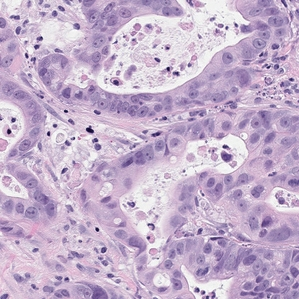

In [10]:
# -----------------------------------------------
# Read single tfrecord and explore single example
# -----------------------------------------------

# ds = tf.data.TFRecordDataset(tfr_files[0])
ds = tf.data.TFRecordDataset(te_tfr_files[0])
rec = next(ds.__iter__())
features = tf.io.parse_single_example(rec, features=FEA_SPEC_RSP_DRUG_PAIR)  # returns features for a given example in a dict
print('Feature types in the tfrecord example:\n{}'.format(features.keys()))
print('\nBytes (image_raw):')
img = tf.image.decode_jpeg(features['image_raw'], channels=3)
print(tf.shape(img))
print(img.numpy().shape)

# plt.imshow(img.numpy());
util.np_to_pil(img.numpy())

In [11]:
len(te_tfr_files)

697

In [12]:
ct_list = []
rsp_list = []
im_list = []
idx_list = []

# All tfrecord
# ds = tf.data.TFRecordDataset(tfr_files)
# ds = tf.data.TFRecordDataset(te_tfr_files)

# ds = tf.data.Dataset.from_tensor_slices(te_tfr_files)
# ds = ds.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=4)

# Subset of tfrecords
# ds = tf.data.TFRecordDataset(te_tfr_files[0])  # label 1 (digestive/gastrointestinal)
# ds = tf.data.TFRecordDataset(te_tfr_files[2])  # label 10 (squamous)
ds = tf.data.TFRecordDataset(te_tfr_files[:3])  # get 3 tfrecords

ds = ds.shuffle(buffer_size=300, seed=None)  # shuffles the items within ALL the loaded tfrecords

# Iterate over all elements of the tfrecords
for i, ex in enumerate(ds):
    ex = tf.io.parse_single_example(ex, features=FEA_SPEC_RSP_DRUG_PAIR)
    im_list.append(ex['image_raw'].numpy())
    ct_list.append(ex['ctype'].numpy())
    rsp_list.append(ex['Response'].numpy())
    idx_list.append(ex['index'].numpy())
    

# print('Number of files:   ', len(tfr_files))
print('Number of elements:', len(ct_list))
print('Unique ctypes:     ', np.unique(ct_list))
# print('bincount:          ', np.bincount(ctl_list))
# print('\nctype label:\n{}'.format(ctl_list))
# print('\ntile id:\n{}'.format(id_list[:10]))

Number of elements: 1092
Unique ctypes:      [b'digestive/gastrointestinal' b'sarcoma/mesothelioma']


# Suggestions on data loading pipeline
- https://github.com/tensorflow/tensorflow/issues/14857 
- https://github.com/jkjung-avt/keras_imagenet/blob/master/utils/dataset.py
- https://jkjung-avt.github.io/tfrecords-for-keras/

In [13]:
# # ----------------------
# # The effect of repeat()
# # ----------------------
# sub_files = vl_tfr_files[:4]

# # One repeat
# print('\nOne repeat:')
# repeat = 1
# shards = tf.data.Dataset.from_tensor_slices(sub_files)
# shards = shards.repeat(repeat)
# _ = [print(f) for i, f in enumerate(shards)]

# # Two repeat
# print('\nTwo repeats:')
# repeat = 2
# shards = tf.data.Dataset.from_tensor_slices(sub_files)
# shards = shards.repeat(repeat)
# _ = [print(f) for i, f in enumerate(shards)]

In [14]:
# # -----------------------
# # The effect of shuffle()
# # -----------------------
# sub_files = vl_tfr_files[:8]
# buffer_size = 2
# # buffer_size = len(sub_files)
# repeat = 1
# seed = 0

# print('\nWithout shuffle (one repeat):')
# shards = tf.data.Dataset.from_tensor_slices(sub_files)
# shards = shards.repeat(repeat)
# _ = [print(f) for i, f in enumerate(shards)]

# print('\nWith shuffle (buffer_size=2) (one repeat):')
# shards = tf.data.Dataset.from_tensor_slices(sub_files)
# shards = shards.repeat(repeat)
# shards = shards.shuffle(buffer_size=buffer_size, seed=seed)
# _ = [print(f) for i, f in enumerate(shards)]

In [15]:
dataset = tf.data.Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
# NOTE: New lines indicate "block" boundaries.
# repeat=1
# repeat=2
# repeat=3
# repeat=4
repeat=5
# repeat=6
dataset = dataset.interleave(
    lambda x: tf.data.Dataset.from_tensors(x).repeat(repeat),
    cycle_length=2, block_length=4)
list(dataset.as_numpy_iterator())

[1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 5, 5, 5, 5, 5]

In [16]:
parse_fn = parse_tfrec_fn_rsp
parse_fn_kwargs = {
    "use_tile": "use_tile",
    "use_ge": use_ge,
    "use_dd1": use_dd1,
    "use_dd2": use_dd2,
    "ge_scaler": ge_scaler,
    "dd1_scaler": dd1_scaler,
    "dd2_scaler": dd2_scaler,
    "id_name": id_name,
    "MODEL_TYPE": "categorical",
    "AUGMENT": False,
}

In [20]:
tf_data = create_tf_data(
    tfrecords=te_tfr_files,
    n_concurrent_shards=16,
    shuffle_size=8192,
    epochs=1,
    batch_size=512,
    drop_remainder=False,
    seed=None,
    prefetch=1,
    parse_fn=parse_fn,
    include_meta=True,
    **parse_fn_kwargs)

In [21]:
bb = next(tf_data.take(1).__iter__())

for i, item in enumerate(bb):
    print(f"\nItem {i}")
    if isinstance(item, dict):
        for k in item.keys():
            print(f"\t{k}: {item[k].numpy().shape}")


Item 0
	tile_image: (512, 299, 299, 3)
	ge_data: (512, 942)
	dd1_data: (512, 1993)
	dd2_data: (512, 1993)

Item 1
	Response: (512,)

Item 2
	index: (512,)
	smp: (512,)
	Group: (512,)
	grp_name: (512,)
	Response: (512,)
	Sample: (512,)
	model: (512,)
	patient_id: (512,)
	specimen_id: (512,)
	sample_id: (512,)
	image_id: (512,)
	ctype: (512,)
	csite: (512,)
	Drug1: (512,)
	Drug2: (512,)
	trt: (512,)
	aug: (512,)


In [19]:
batches = []
batch_sz = []
index = []
for i, batch in enumerate(tf_data):
    if (i+1)%20 == 0: print(i+1)
    batches.append(i+1)
    indices = batch[2]["index"]
    index.append(indices)
    batch_sz.append(len(indices))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
40
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
60
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
80
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
100
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
120
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
140
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
160
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
180
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
200
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
220
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
240
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
260
259
260
261
262
263
264
26

In [22]:
index

[<tf.Tensor: shape=(306,), dtype=string, numpy=
 array([b'98', b'6487', b'6487', b'98', b'98', b'98', b'98', b'98', b'98',
        b'98', b'98', b'98', b'98', b'6487', b'98', b'98', b'98', b'98',
        b'98', b'98', b'98', b'98', b'98', b'98', b'98', b'98', b'98',
        b'98', b'98', b'98', b'98', b'98', b'98', b'6487', b'6487', b'98',
        b'98', b'98', b'98', b'98', b'98', b'6487', b'98', b'6487',
        b'6487', b'98', b'98', b'98', b'98', b'98', b'98', b'98', b'98',
        b'98', b'98', b'6487', b'98', b'6487', b'6487', b'98', b'98',
        b'98', b'6487', b'98', b'98', b'98', b'6487', b'98', b'98', b'98',
        b'98', b'6487', b'98', b'98', b'98', b'98', b'98', b'98', b'98',
        b'98', b'98', b'98', b'98', b'6487', b'6487', b'6487', b'6487',
        b'98', b'98', b'98', b'98', b'6487', b'6487', b'98', b'98',
        b'6487', b'6487', b'6487', b'6487', b'98', b'98', b'98', b'6487',
        b'98', b'6487', b'98', b'6487', b'98', b'98', b'98', b'98',
        b'6487', 

In [14]:
# fig, axes = plt.subplots(1, 4, figsize=(17, 5), constrained_layout=True)
# axes = axes.ravel()

# img_dim = 300
# for i, ex in enumerate(dataset.take(4)):
#     ex = tf.io.parse_single_example(ex, features=FEA_SPEC)
#     img = ex['image_raw']
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.cast(img, tf.float32) / 255.0
#     img = tf.image.resize(images=img, size=(img_dim, img_dim),
#                       method=tf.image.ResizeMethod.BILINEAR,
#                       preserve_aspect_ratio=False)
#     img = tf.image.random_flip_left_right(img)
#     img = tf.image.random_flip_up_down(img)
#     axes[i].imshow(img)
#     axes[i].set_title('tile_id={}, ctype_label={}'.format(ex['tile_id'].numpy().decode('utf-8'), ex['ctype_label']))

In [15]:
# ds = tf.data.TFRecordDataset(te_tfr_files)
# ex = next(ds.take(1).__iter__())
# ii, oo = read_tfr_example(ex)
# print(oo)

# for i, ex in enumerate(ds.shuffle(300).take(5)):
#     ii, oo = read_tfr_example(ex)

aa = []
ds = get_dataset(te_tfr_files)
for i, ex in enumerate(ds.shuffle(300).take(5)):
#     print(i)
    aa.append(ex)

NameError: name 'get_dataset' is not defined

In [17]:
def prepare_image(img, augment=True, img_dim=224):
    """
    Prepare single image for training.
    slideflow/model/_process_image()
    Deotte: www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    img = tf.image.decode_jpeg(img, channels=3)
    
    # slideflow
    if self.normalizer:
        image = tf.py_function(self.normalizer.tf_to_rgb, [image], tf.int32)
    
    # Scale image values
    # img = tf.cast(img, tf.float32) / 255.0  # deotte
    # image = tf.image.per_image_standardization(image)  # slideflow
    
    # Resize image
    # in case, we're using my preprocessing
    # img = tf.image.resize(images=img, size=(img_dim, img_dim), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False)
    
    if augment:
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        
        # https://www.tensorflow.org/api_docs/python/tf/image/random_flip_up_down
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
    img = tf.image.convert_image_dtype(img, tf.float32)  # slideflow
    img.set_shape([self.IMAGE_SIZE, self.IMAGE_SIZE, 3])  # slideflow
    return img

In [18]:
def read_tfr_example(ex, augment=True, img_dim=224):
    """
    Read and parse a single example from a tfrecord, and prepare
    inputs and outputs for TF model training.
    """
    # print('Inside read_tfr_example() ...')
    
    ex = tf.io.parse_single_example(ex, FEA_SPEC)

    # Inputs
    img = ex['image_raw']
    img = prepare_image(img, augment=augment, img_dim=img_dim)  # Deotte
    #ge_vec = tf.cast(ex['ge_vec'], tf.float32)
    #dd_vec = tf.cast(ex['dd_vec'], tf.float32)
    inputs = {'img': img}

    # Outputs
    #label = tf.cast(ex['label'], tf.int64)  # cats and dogs
    ctype_label = tf.cast(ex['ctype_label'], tf.int64)
    
    # print('Before', ctype_label)
    if tf.equal(ctype_label, tf.constant(10, tf.int64)):
    # if ctype_label == 10:
        ctype_label = tf.constant(0, tf.int64)
    # print('After ', ctype_label)
    
    outputs = {'ctype_label': ctype_label}

    return inputs, outputs

In [19]:
def get_dataset(files: List[str],
                cache: bool=True,
                shuffle: bool=False,
                repeat: Union[bool, int]=False, 
                augment: bool=False,
                prefetch: Optional[int]=1,
                labeled: bool=False,
                batch_size: int=32,
                img_dim: int=224,
                seed=None):
    """ Create and return tf dataset using tfrecord files passed in files. """
    # print('Inside get_dataset() ...')
    
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=1)
    
    # -----------------------------------------------------------------------------
    # https://github.com/tensorflow/tensorflow/issues/14857

    # 1. Randomly shuffle the entire data once using a MapReduce/Spark/Beam/etc. job
    #    to create a set of roughly equal-sized files ("shards").
    
    shards = tf.data.Dataset.from_tensor_slices(files)  # data shards

    # 2. In each epoch:
    # i. Randomly shuffle the list of shard filenames, using Dataset.list_files(...).shuffle(num_shards).

    shards = shards.shuffle(len(shards), seed=seed)  # shuffle the list of shard filenames
    # shards = shards.repeat()
    
    # ii. Use dataset.interleave(lambda filename: tf.data.TextLineDataset(filename), cycle_length=N)
    #     to mix together records from N different shards.
    
    cycle_length = 8  # default: tf.data runtime decides what it should be based on available CPU
    # cycle_length = 1
    block_length = 1  # default: 1
    num_parallel_calls = None  # default: default behavior is to fetch inputs from cycle elements synchronously with no parallelism
    dataset = shards.interleave(
        lambda x: tf.data.TFRecordDataset(x, num_parallel_reads=None),
        cycle_length=cycle_length,
        block_length=block_length,
        num_parallel_calls=num_parallel_calls,
        deterministic=False
    )
    
    # instead of step 2.ii.
    # ds = tf.data.TFRecordDataset(shards, num_parallel_reads=None)
    
    # (ap) it seems that cache comes after TFRecordDataset()
    if cache:
        dataset = dataset.cache()
    
    # iii. Use dataset.shuffle(B) to shuffle the resulting dataset. Setting B might require some experimentation,
    #      but you will probably want to set it to some value larger than the number of records in a single shard.
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2048)  # (ap) shuffles the examples in the relevant filenames    

    # -----------------------------------------------------------------------------
    
    # (ap) why do we need repeat if we specify epochs in the model.fit() ??
    if repeat is True:
        dataset = dataset.repeat()
    elif isinstance(repeat, int) and repeat > 0:
        dataset = dataset.repeat(repeat)

    # num_parallel_calls = AUTO
    num_parallel_calls = 8
    # num_parallel_calls = None
    dataset = dataset.map(lambda ex: read_tfr_example(ex, augment=augment, img_dim=img_dim),
                num_parallel_calls=num_parallel_calls)

    dataset = dataset.batch(batch_size)

    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
    # ds = ds.prefetch(buffer_size=AUTO)
    if prefetch is not None:
        dataset = dataset.prefetch(buffer_size=prefetch)
    return dataset

In [20]:
def get_dataset(files: List[str],
                cache: bool=True,
                shuffle: bool=False,
                repeat: Union[bool, int]=False, 
                augment: bool=False,
                prefetch: Optional[int]=1,
                labeled: bool=False,
                batch_size: int=32,
                img_dim: int=224,
                seed=None):
    """ Create and return tf dataset using tfrecord files passed in files. """
    # print('Inside get_dataset() ...')
    
    # -----------------------------------------------------------------------------
    # https://github.com/tensorflow/tensorflow/issues/14857

    # 1. Randomly shuffle the entire data once using a MapReduce/Spark/Beam/etc. job
    #    to create a set of roughly equal-sized files ("shards").
    
    shards = tf.data.Dataset.from_tensor_slices(files)  # data shards

    # 2. In each epoch:
    # i. Randomly shuffle the list of shard filenames, using Dataset.list_files(...).shuffle(num_shards).
    
    shards = shards.shuffle(len(shards), seed=seed)  # shuffle the list of shard filenames
    # shards = shards.repeat()
    
    # ii. Use dataset.interleave(lambda filename: tf.data.TextLineDataset(filename), cycle_length=N)
    #     to mix together records from N different shards.
    
    cycle_length = 8  # default: tf.data runtime decides what it should be based on available CPU
    # cycle_length = 1
    block_length = 1  # default: 1
    num_parallel_calls = None  # default: default behavior is to fetch inputs from cycle elements synchronously with no parallelism
    dataset = shards.interleave(
        lambda x: tf.data.TFRecordDataset(x, num_parallel_reads=None),
        cycle_length=cycle_length,
        block_length=block_length,
        num_parallel_calls=num_parallel_calls,
        deterministic=False
    )
    
    # instead of step 2.ii.
    # ds = tf.data.TFRecordDataset(shards, num_parallel_reads=None)
    
    # (ap) it seems that cache comes after TFRecordDataset()
    if cache:
        dataset = dataset.cache()
    
    # iii. Use dataset.shuffle(B) to shuffle the resulting dataset. Setting B might require some experimentation,
    #      but you will probably want to set it to some value larger than the number of records in a single shard.
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2048)  # (ap) shuffles the examples in the relevant filenames    

    # -----------------------------------------------------------------------------
    
    # (ap) why do we need repeat if we specify epochs in the model.fit() ??
    if repeat is True:
        dataset = dataset.repeat()
    elif isinstance(repeat, int) and repeat > 0:
        dataset = dataset.repeat(repeat)

    # num_parallel_calls = AUTO
    num_parallel_calls = 8
    # num_parallel_calls = None
    dataset = dataset.map(lambda ex: read_tfr_example(ex, augment=augment, img_dim=img_dim),
                num_parallel_calls=num_parallel_calls)

    dataset = dataset.batch(batch_size)

    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
    # ds = ds.prefetch(buffer_size=AUTO)
    if prefetch is not None:
        dataset = dataset.prefetch(buffer_size=prefetch)
    return dataset

In [21]:
# -----------------------------------------------
# Read single tfrecord and explore single example
# -----------------------------------------------
# ds = tf.data.TFRecordDataset(filenames=tr_tfr_files)
# ds = ds.map(lambda ex: read_tfr_example(ex, augment=True))
kwargs = {'batch_size': 32,
          'shuffle': True,
          'augment': False,
          'repeat': False,
          'prefetch': 5,
          'img_dim': 150}

ds = get_dataset(te_tfr_files, **kwargs)

# Take an example
ex = next(ds.take(count=1).__iter__())  # creates Dataset with at most 'count' elements from this dataset.
# ex = next(ds.__iter__())
print('Inputs: ', ex[0].keys())
print('Outputs:', ex[1].keys())

print('\nInput features:')
for i, fea_name in enumerate(ex[0].keys()):
    print(fea_name, ex[0][fea_name].numpy().shape)
    
print('\nOutputs:')
for i, out_name in enumerate(ex[1].keys()):
    print(out_name, ex[1][out_name].numpy())

Inputs:  dict_keys(['img'])
Outputs: dict_keys(['ctype_label'])

Input features:
img (32, 150, 150, 3)

Outputs:
ctype_label [0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0]


In [22]:
print(ex[0]['img'].numpy().shape)
print(ex[0]['img'].numpy()[0].shape)

(32, 150, 150, 3)
(150, 150, 3)


In [23]:
ds = get_dataset(te_tfr_files, **kwargs)
for i, ex in enumerate(ds.take(2)):
    print(ex[0]['img'].shape)
    print(ex[1]['ctype_label'].shape)

(32, 150, 150, 3)
(32,)
(32, 150, 150, 3)
(32,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


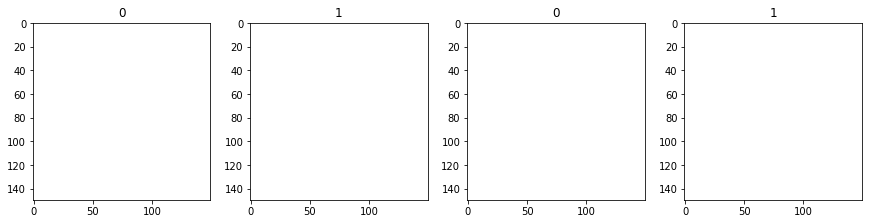

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
axes = axes.ravel()
for i, ex in enumerate(ds.take(4)):
    idx = 31  # take an element of the current batch
    axes[i].imshow(ex[0]['img'].numpy()[idx])
    axes[i].set_title(ex[1]['ctype_label'].numpy()[idx])